In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

In [11]:
np.expand_dims??

Signature:       np.expand_dims(a, axis)
Call signature:  np.expand_dims(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function expand_dims at 0x0000020C5BEA17E0>
File:            c:\users\lenovo\.conda\envs\py310\lib\site-packages\numpy\lib\shape_base.py
Source:         
@array_function_dispatch(_expand_dims_dispatcher)
def expand_dims(a, axis):
    """
    Expand the shape of an array.

    Insert a new axis that will appear at the `axis` position in the expanded
    array shape.

    Parameters
    ----------
    a : array_like
        Input array.
    axis : int or tuple of ints
        Position in the expanded axes where the new axis (or axes) is placed.

        .. deprecated:: 1.13.0
            Passing an axis where ``axis > a.ndim`` will be treated as
            ``axis == a.ndim``, and passing ``axis < -a.ndim - 1`` will
            be treated as ``axis == 0``. This behavior is deprecated.

        .. versionchanged:: 1.18.0
            A tuple 

In [12]:
# kernel python 3.10

In [13]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [15]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [17]:
df.iloc[3]['comment_text']

'"\r\nMore\r\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\r\n\r\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [22]:
df[df.columns[2:]].iloc[3]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 3, dtype: int64

# 1. Preprocess

In [24]:
from tensorflow.keras.layers import TextVectorization #tokenization|

In [27]:
TextVectorization??

Init signature:
TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    **kwargs,
)
Source:        
@keras_export(
    "keras.layers.TextVectorization",
    "keras.layers.experimental.preprocessing.TextVectorization",
    v1=[],
)
class TextVectorization(base_preprocessing_layer.PreprocessingLayer):
    """A preprocessing layer which maps text features to integer sequences.

    This layer has basic options for managing text in a Keras model. It
    transforms a batch of strings (one example = one string) into either a list
    of token indices (one example = 1D tensor of integer token indices) or a
    dense representation (one example = 1D tensor of float values representing
    data about the example's tokens). This layer is meant to handle natura

In [28]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [29]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [31]:
X

0         Explanation\r\nWhy the edits made under my use...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\r\nMore\r\nI can't make any real suggestions...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \r\n\r\nThat...
159568    Spitzer \r\n\r\nUmm, theres no actual article ...
159569    And it looks like it was actually you who put ...
159570    "\r\nAnd ... I really don't think you understa...
Name: comment_text, Length: 159571, dtype: object

In [32]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [34]:
MAX_FEATURES = 200000 #number of words in the vocab

In [35]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                              output_sequence_length=1800,
                              output_mode='int')

In [39]:
X

0         Explanation\r\nWhy the edits made under my use...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\r\nMore\r\nI can't make any real suggestions...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \r\n\r\nThat...
159568    Spitzer \r\n\r\nUmm, theres no actual article ...
159569    And it looks like it was actually you who put ...
159570    "\r\nAnd ... I really don't think you understa...
Name: comment_text, Length: 159571, dtype: object

In [40]:
type(X)

pandas.core.series.Series

In [41]:
X.values #mengubah X pandas series ke numpy

array(["Explanation\r\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \r\n\r\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\r\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of 

In [36]:
vectorizer.adapt(X.values)

In [62]:
vectorizer('Hello Bang')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([ 286, 4763,    0, ...,    0,    0,    0], dtype=int64)>

In [46]:
# vectorizer.get_vocabulary()

In [47]:
vectorized_text = vectorizer(X.values)
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  643,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2506, ...,     0,     0,     0],
       [  425,   440,    70, ...,     0,     0,     0],
       ...,
       [32141,  7329,   383, ...,     0,     0,     0],
       [    5,    12,   533, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [48]:
# MCSHBAP -- map, cache, shuffle, batch, prefetch from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [52]:
dataset.as_numpy_iterator().next()

(array([[1581, 1574,   40, ...,    0,    0,    0],
        [  23,  244,    9, ...,    0,    0,    0],
        [1857,    5,  302, ...,    0,    0,    0],
        ...,
        [   7, 2486,   30, ...,    0,    0,    0],
        [ 170,  122,    8, ...,    0,    0,    0],
        [   8,   74,  239, ...,    0,    0,    0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0]], dtype=int64))

In [50]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [57]:
print('Ukuran Batch X', batch_X.shape)
print('Ukuran Batch y', batch_y.shape)

Ukuran Batch X (16, 1800)
Ukuran Batch y (16, 6)


In [69]:
# len(dataset)*16 jml total_data

In [54]:
train = dataset.take(int(len(dataset)*.7)) # 70% dari len dataset
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [66]:
print('Jumal data train', len(train))
print('Jumal data val', len(val))
print('Jumal data test', len(test))

Jumal data train 6981
Jumal data val 1994
Jumal data test 997


In [71]:
train_generator = train.as_numpy_iterator()

In [72]:
train_generator.next()

(array([[ 265,   10,   25, ...,    0,    0,    0],
        [   7,  677,    4, ...,    0,    0,    0],
        [ 124,    7, 9346, ...,    0,    0,    0],
        ...,
        [  70,   15,  164, ...,    0,    0,    0],
        [ 265,   35,   10, ...,    0,    0,    0],
        [  48,  352,   10, ...,    0,    0,    0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

# 2. Create Sequential Model

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [85]:
model = Sequential()

#create embedding layers
model.add(Embedding(MAX_FEATURES +1, 32))

# #Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# model.add(LSTM(32, activation='tanh'))

#Feature extractor fully
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

#final layer
model.add(Dense(6, activation='sigmoid'))

In [86]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [87]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 6)                 774       
                                                      

disaranin epochs 10

In [89]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 2204s 314ms/step - loss: 0.0617 - val_loss: 0.0449


In [90]:
history.history

{'loss': [0.06167217344045639], 'val_loss': [0.04491858556866646]}

In [91]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

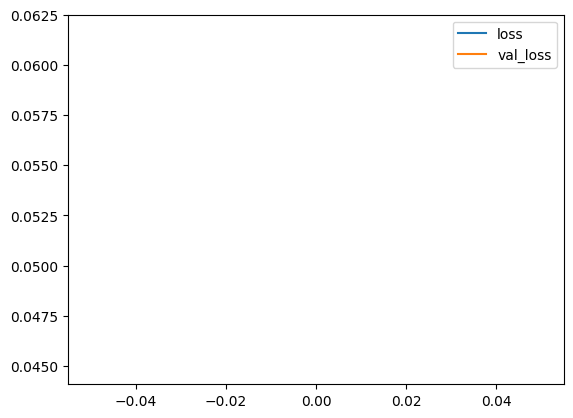

In [92]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [109]:
input_text = vectorizer('You freaking suck! i will to kill you')

In [113]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [110]:
# model.predict(np.array([input_text]))
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 495ms/step


array([[0.99439526, 0.3512241 , 0.94991744, 0.07631917, 0.7939208 ,
        0.20017867]], dtype=float32)

In [99]:
batch = test.as_numpy_iterator().next()

In [111]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [114]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 490ms/step


array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0]])

In [108]:
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 468ms/step


# 4. Evaluate Model

In [115]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [116]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [118]:
for batch in test.as_numpy_iterator():
    #unpack batch
    X_true, y_true = batch

    #make prediction
    yhat = model.predict(X_true)

    #flatten the prediction
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 137ms/step


In [120]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7868520021438599, Recall:0.7627737522125244, Accuracy:0.4814443290233612


# 5. Test and Gradio

In [121]:
!pip install gradio jinja2

  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached httpx-0.27.0-py3-none-any.whl.metadata (7.2 kB)
     ---------------------------------------- 0.0/50.9 kB ? eta -:--:--
     ---------------------------------------- 50.9/50.9 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/107.3 kB ? eta -:--:--
     -------------------------------------- 107.3/107.3 kB 3.0 MB/s eta 0:00:00
  Using cached jsonschema-4.22.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached anyio-4.3.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached httpcore-1.0.5-py3-none-any.whl.metadata (20 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached h11-0.14.0-py3-none-any.whl.metadata (8.2 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached rich-13.7.

In [146]:
import gradio as gr

In [139]:
model.save('toxic.h5')

In [140]:
model = tf.keras.models.load_model('toxic.h5')

In [141]:
input_str = vectorizer('you are ugly')

In [142]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 1s/step


In [143]:
res

array([[0.90842664, 0.04118547, 0.6266571 , 0.03426718, 0.5350182 ,
        0.07258698]], dtype=float32)

In [159]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    result = model.predict(vectorized_comment)

    # print kelas klasifikasinya
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, result[0][idx]>0.5)  # Changed results to result

    return text

In [160]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                         outputs='text')

harus matiin antivirus

In [161]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://59dfb9b1d3c665e0f6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 1s 535ms/step
